In [1]:
from bs4 import BeautifulSoup
import requests
import lxml
import re
import os
import json

## 下边这个是对应的几号线的css copy selector，准备用这个进行爬取几号线的信息，并且隔离出每条地铁线的地铁站信息

In [2]:
line_rails = '''
body > div > div.content > div.sub_map > div.line_content > div:nth-child(1) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(25) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(44) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(69) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(93) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(128) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(150) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(183) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(197) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(243) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(260) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(291) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(312) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(323) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(337) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(350) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(365) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(377) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(382) > div
body > div > div.content > div.sub_map > div.line_content > div:nth-child(395) > div
'''

# 我爬取的是北京地铁的网站-->站点和周边信息

In [3]:
user_agent ='Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36'
headers = {'User_Agent': user_agent}
sessions = requests.session()
sessions.keep_alive = False
url = 'https://www.bjsubway.com/station/xltcx/'
#url = 'https://www.bjsubway.com/e/action/ListInfo/?classid=39&ph=1'
sessions.headers = headers
content = sessions.get(url,allow_redirects=True,verify = False)
content.encoding = 'gbk'

soup = BeautifulSoup(content.text, 'lxml')

rails_num =[]
row_num = []
line_pattern = r'(\d+.^A\w+|\w+线)'  # 匹配地铁线编号
line_row_num = r'(\d+)'  # 这个是匹配line_rails的数字
station_re = r'>(\w+)'  # 这个是匹配站点名称

sum_count = list(range(1,403))  # 地铁线的条数 + 地铁站点总共是402条网站信息

d:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [4]:
def Arr_split(a, b):
    num_arr1 = []
    num_arr2 = []
    num_arr3 = []
    for i in a:
        num_arr1.append(i)
        # print(num_arr1)
        if num_arr1[-1] in b:
            num_arr1.pop()
            # b.pop(0)
            num_arr2 += [num_arr1.copy()]  # 可变对象赋值果然是个坑
            # print(num_arr2)
            num_arr1.clear()
            b.pop(0)
        elif not b:
            num_arr2 += [a[a.index(i):]]
            return num_arr2

## 这个函数是用来把地铁站几号线信息和每条线包含的站点拿出来，组成字典

In [5]:
def rail_meg():
    railways_meg = {}
    rail_lines_msg = list()
    for line in line_rails.split('\n'):
        if not line: continue
        # print(str(line))
        row_num.append(int(re.findall(line_row_num, str(line))[0]))
        #print(row_num)
        sets = str(soup.select(line)[0])
        rail_lines_msg.append(re.findall(line_pattern, sets))
    #return rail_lines_msg
    # 切片，除去每个地铁的线路信息
    #return rail_lines_msg
    per_rail_stations_num_sets = Arr_split(sum_count, row_num)
    #return  per_rail_stations_num_sets

    station = []
    stations = []
    for per_rail_station__num in per_rail_stations_num_sets:
        if not per_rail_station__num: continue
        #print(per_rail_station__num)
        for rail_station__num in per_rail_station__num:
            try:
                rail_station_with_tag = str(soup.select('body > div > div.content > div.sub_map > div.line_content > div:nth-child(' +
                                                    str(rail_station__num) + ') > a')[0])
            except IndexError:
                rail_station_with_tag = str(
                    soup.select('body > div > div.content > div.sub_map > div.line_content > div:nth-child(' +
                                str(rail_station__num) + ')')[0])

            station.append(re.findall(station_re, rail_station_with_tag)[0])
        stations += [station.copy()]
        station.clear()

    for i in range(len(rail_lines_msg)):
          railways_meg[rail_lines_msg[i][0]] = stations[i]

    return railways_meg  # 地铁站和线路的对应信息

In [6]:
def check_local_subway_file():
    for root, dirs, files in os.walk(".", topdown=False):
        if 'subway.txt' not in files:  # 这句判断当前目录里有没有subway.txt，如果有，直接从这个文件里读取，因为每次爬都很慢
            # print(False)
            json_dict = json.dumps(rail_meg())
            f = open('subway.txt', 'w')
            f.write(json_dict)
            subway_data = json.loads(subway_dict)
            f.close()
        else:
            f = open('subway.txt', 'r')
            subway_dict = f.read()
            subway_data = json.loads(subway_dict)

    return subway_data

In [7]:
check_local_subway_file()

NotImplementedError: Only the following pseudo-classes are implemented: nth-of-type.

## 这个报错了，但我在pycharm上可以运行，并且我把py文件也上传到github了，老师请看下，那个程序运行没问题的。

In [8]:
sub_staion_data = {'苹果园': (116.177388,39.926727), '古城': (116.190337, 39.90745), '八角游乐园': (116.212684, 39.907442), '八宝山': (116.235948, 39.90744), '玉泉路': (116.2529, 39.907431), '五棵松': (116.274071, 39.907214), '万寿路': (116.294765, 39.907474), '公主坟': (116.309919, 39.907469), '军事博物馆': (116.323385, 39.907422), '木樨地': (116.335644, 39.907546), '南礼士路': (116.40307, 39.933814), '复兴门': (116.356866, 39.907242), '西单': (116.374143, 39.907585), '天安门西': (116.391878, 39.907611), '天安门东': (116.401216, 39.90778), '王府井': (116.411484, 39.908902), '东单': (116.420327, 39.908317), '建国门': (116.434914, 39.9085), '永安里': (116.450497, 39.908454), '国贸': (116.461841, 39.909104), '大望路': (116.476132, 39.90867), '四惠': (116.493449, 39.909048), '四惠东': (116.515664, 39.908495), '西直门': (116.353226, 39.94167), '积水潭': (116.371954, 39.948567), '鼓楼大街': (116.393776, 39.948972), '安定门': (116.40824, 39.94918), '雍和宫': (116.417069, 39.949336), '东直门': (116.435102, 39.942352), '东四十条': (116.434133, 39.933801), '朝阳门': (116.435782, 39.924885), '北京站': (116.427287, 39.904983), '崇文门': (116.418472, 39.900825), '前门': (116.360286, 40.071857), '和平门': (116.384209, 39.900098), '宣武门': (116.374314, 39.899765), '长椿街': (116.363355, 39.899433), '阜成门': (116.356009, 39.923686), '车公庄': (116.354357, 39.932397), '安河桥北': (116.270127, 40.013608), '北宫门': (116.407267, 40.056289), '西苑': (116.291278, 39.997796), '圆明园': (116.310186, 39.999662), '北京大学东门': (116.315842, 39.992212), '中关村': (116.316037, 39.983918), '海淀黄庄': (116.317564, 39.975996), '人民大学': (116.322121, 39.967047), '魏公村': (116.32322, 39.957904), '国家图书馆': (116.32519, 39.943114), '动物园': (116.339131, 39.93829), '新街口': (116.367742, 39.940667), '平安里': (116.368045, 39.932411), '西四': (116.373332, 39.924206), '灵境胡同': (116.373746, 39.915912), '菜市口': (116.374425, 39.889296), '陶然亭': (116.374383, 39.87847), '北京南站': (116.379008, 39.865012), '马家堡': (116.371361, 39.853109), '角门西': (116.370384, 39.846122), '公益西桥': (116.370369, 39.838868), '宋家庄': (116.428379, 39.844991), '刘家窑': (116.421019, 39.857675), '蒲黄榆': (116.421664, 39.865588), '天坛东门': (116.420833, 39.882558), '磁器口': (116.41994, 39.893172), '灯市口': (116.417386, 39.917481), '东四': (116.416202, 39.924363), '张自忠路': (116.417156, 39.933592), '北新桥': (116.416884, 39.940782), '和平里北街': (116.418504, 39.958734), '和平西桥': (116.418111, 39.969173), '惠新西街南口': (116.42425, 39.980321), '惠新西街北口': (116.417028, 39.987836), '大屯路东': (116.417377, 40.003841), '北苑路北': (116.454943, 40.020672), '立水桥南': (116.414496, 40.041956), '立水桥': (116.41235, 40.053032), '天通苑南': (116.412661, 40.066458), '天通苑': (116.409892, 40.074067), '天通苑北': (116.417635, 39.977146), '金安桥': (116.163095, 39.923635), '杨庄': (116.301889, 39.814322), '西黄村': (116.20985, 39.933911), '廖公庄': (116.226955, 39.932368), '田村': (116.247554, 39.92935), '海淀五路居': (116.276531, 39.932584), '慈寿寺': (116.293779, 39.932676), '花园桥': (116.444183, 39.940486), '白石桥南': (116.40307, 39.933814), '车公庄西': (116.344082, 39.932466), '北海北': (116.43575, 39.90855), '南锣鼓巷': (116.402993, 39.933118), '东大桥': (116.451512, 39.922913), '呼家楼': (116.461618, 39.923337), '金台路': (116.478065, 39.915614), '十里堡': (116.502045, 39.923076), '青年路': (116.517429, 39.923168), '褡裢坡': (116.563961, 39.924021), '黄渠': (116.578266, 39.924201), '常营': (116.599722, 39.925696), '草房': (116.615574, 39.924477), '物资学院路': (116.444183, 39.940486), '通州北关': (116.661131, 39.917962), '通运门': (116.673284, 39.910583), '北运河西': (116.407267, 40.056289), '北运河东': (116.407267, 40.056289), '郝家府': (116.460904, 39.922979), '东夏园': (116.732371, 39.902924), '潞城': (116.747434, 39.902652), '北京西站': (116.321218, 39.894706), '湾子': (116.182506, 40.22236), '达官营': (116.338408, 39.889345), '广安门内': (116.358239, 39.889418), '虎坊桥': (116.384596, 39.889486), '珠市口': (116.398695, 39.890794), '桥湾': (116.408464, 39.892725), '广渠门内': (116.433877, 39.893673), '广渠门外': (116.448998, 39.893648), '双井': (116.461834, 39.893512), '九龙山': (116.478695, 39.893222), '大郊亭': (116.487935, 39.893183), '百子湾': (116.497768, 39.89253), '化工': (116.504276, 39.884026), '南楼梓庄': (116.501084, 39.874578), '欢乐谷景区': (116.500067, 39.866505), '垡头': (116.511829, 39.860864), '双合': (116.526595, 39.860966), '焦化厂': (116.537247, 39.855488), '朱辛庄': (116.313698, 40.104297), '育知路': (116.326992, 40.087863), '平西府': (116.34894, 40.089704), '回龙观东大街': (116.363025, 40.081175), '霍营': (116.360286, 40.071857), '育新': (116.347328, 40.060039), '西小口': (116.350536, 40.046615), '永泰庄': (116.355359, 40.035086), '林萃桥': (116.372998, 40.021906), '森林公园南门': (116.392701, 40.009908), '奥林匹克公园': (116.391758, 40.002207), '奥体中心': (116.393537, 39.986229), '北土城': (116.407267, 40.056289), '安华桥': (116.394655, 39.968507), '安德里北街': (116.395145, 39.957227), '什刹海': (116.371954, 39.948567), '中国美术馆': (116.407526, 39.90403), '天桥': (116.581181, 39.912359), '永定门外': (116.399369, 39.867435), '木樨园': (116.403152, 39.857718), '海户屯': (116.397955, 39.852166), '大红门': (116.40062, 39.845552), '大红门南': (116.248154, 40.065575), '和义': (116.402247, 39.814412), '东高地': (116.421327, 39.808136), '火箭万源': (116.505591, 39.802341), '五福堂': (116.407526, 39.90403), '德茂': (116.407526, 39.90403), '瀛海': (116.448813, 39.760994), '郭公庄': (116.299571, 39.814071), '丰台科技园': (116.297176, 39.825233), '科怡路': (116.297432, 39.83248), '丰台南路': (116.296748, 39.840444), '丰台东大街': (116.293857, 39.855111), '七里庄': (116.293696, 39.866043), '六里桥': (116.315142, 39.886886), '六里桥东': (116.314831, 39.886468), '白堆子': (116.329909, 39.926601), '巴沟': (116.293727, 39.974179), '苏州街': (116.306332, 39.975642), '知春里': (116.328709, 39.976334), '知春路': (116.341479, 39.975988), '西土城': (116.352527, 39.977198), '牡丹园': (116.371271, 39.978151), '健德门': (116.381353, 39.976723), '安贞门': (116.405954, 39.977005), '芍药居': (116.437144, 39.977024), '太阳宫': (116.447469, 39.972678), '三元桥': (116.438492, 39.961727), '亮马桥': (116.461794, 39.949415), '农业展览馆': (116.465145, 39.940528), '团结湖': (116.461806, 39.933747), '金台夕照': (116.461743, 39.916838), '劲松': (116.461325, 39.884387), '潘家园': (116.460926, 39.875387), '十里河': (116.457983, 39.866417), '分钟寺': (116.453976, 39.852227), '成寿寺': (116.447531, 39.845874), '石榴庄': (116.414103, 39.845905), '角门东': (116.385649, 39.845135), '草桥': (116.346605, 39.84487), '纪家庙': (116.333381, 39.844433), '首经贸': (116.320568, 39.844381), '丰台站': (116.303943, 39.849611), '泥洼': (116.304173, 39.858609), '西局': (116.444183, 39.940486), '莲花桥': (116.310204, 39.897035), '西钓鱼台': (116.298064, 39.923481), '车道沟': (116.293818, 39.947923), '长春桥': (116.34147, 39.976451), '火器营': (116.417847, 39.97775), '大钟寺': (116.343769, 39.966839), '五道口': (116.337742, 39.992894), '上地': (116.319359, 40.032677), '西二旗': (116.309585, 40.062594), '龙泽': (116.319429, 40.070882), '回龙观': (116.336116, 40.0708), '北苑': (116.454943, 40.020672), '望京西': (116.447359, 39.995084), '光熙门': (116.43129, 39.969536), '柳芳': (116.433144, 39.958419), '张郭庄': (116.187193, 39.8581), '园博园': (116.190959, 39.875252), '大瓦窑': (116.24048, 39.85947), '郭庄子': (116.253068, 39.864841), '大井': (116.375691, 39.910224), '善各庄': (116.478195, 40.02716), '陶然桥': (116.407526, 39.90403), '景泰': (116.411316, 39.86426), '方庄': (116.438388, 39.865646), '北工大西门': (116.208169, 39.930615), '平乐园': (116.475145, 39.88025), '朝阳公园': (116.477774, 39.933173), '枣营': (116.474947, 39.944132), '东风北桥': (116.485919, 39.958375), '高家园': (116.489905, 39.980286), '阜通': (116.47174, 39.991699), '望京': (116.469409, 39.998521), '将台': (116.489496, 39.971109), '望京南': (116.481634, 39.984634), '东湖渠': (116.467412, 40.01067), '来广营': (116.466994, 40.020588), '俸伯': (116.686148, 40.13248), '顺义': (116.657023, 40.129994), '石门': (116.640596, 40.129404), '南法信': (116.609734, 40.127144), '后沙峪': (116.564211, 40.114127), '花梨坎': (116.557593, 40.084436), '国展': (116.493827, 40.022596), '孙河': (116.5347, 40.045113), '马泉营': (116.503663, 40.034001), '崔各庄': (116.492968, 40.022201), '望京东': (116.488046, 40.002253), '关庄': (116.430947, 40.001134), '安立路': (116.407845, 40.002619), '北沙滩': (116.407267, 40.056289), '六道口': (116.35267, 40.000958), '清华东路西口': (116.40307, 39.933814), '农大南路': (116.282012, 40.021681), '马连洼': (116.27252, 40.032637), '西北旺': (116.257923, 40.048703), '永丰南': (116.248154, 40.065575), '永丰': (116.347299, 40.022079), '屯佃': (116.21585, 40.068454), '稻香湖路': (116.188145, 40.068936), '温阳路': (116.161361, 40.068516), '北安河': (116.407267, 40.056289), '高碑店': (116.531421, 39.909448), '传媒大学': (116.554639, 39.909215), '双桥': (116.581181, 39.912359), '管庄': (116.599002, 39.90909), '八里桥': (116.618658, 39.906121), '通州北苑': (116.637742, 39.903509), '果园': (116.644937, 39.892712), '九棵树': (116.657722, 39.890503), '梨园': (116.666558, 39.883172), '临河里': (116.6789, 39.875517), '土桥': (116.686349, 39.871926), '昌平西山口': (116.195369, 40.244629), '十三陵景区': (116.207726, 40.240261), '昌平': (116.233601, 40.22055), '昌平东关': (116.262059, 40.221726), '北邵洼': (116.407267, 40.056289), '南邵': (116.287534, 40.207492), '沙河高教园': (116.280465, 40.164666), '沙河': (116.292915, 40.147729), '巩华城': (116.293979, 40.1309), '生命科学园': (116.340917, 39.976391), '肖村': (116.448377, 39.834222), '小红门': (116.458965, 39.828598), '旧宫': (116.459339, 39.805683), '亦庄桥': (116.480249, 39.802997), '亦庄文化园': (116.490914, 39.806232), '万源街': (116.505403, 39.802971), '荣京东街': (116.40307, 39.933814), '荣昌东街': (116.4285, 39.845055), '同济南路': (116.539805, 39.772915), '经海路': (116.562207, 39.78362), '次渠南': (116.581357, 39.795118), '次渠': (116.447499, 39.83225), '亦庄火车站': (116.602475, 39.813215), '大葆台': (116.291681, 39.80781), '稻田': (116.21884, 39.794885), '长阳': (116.212692, 39.763871), '篱笆房': (116.353307, 39.9413), '广阳城': (116.184985, 39.74793), '良乡大学城北': (116.18348, 39.729906), '良乡大学城': (116.176541, 39.723159), '良乡大学城西': (116.156282, 39.723157), '良乡南关': (116.140804, 39.723202), '苏庄': (116.123209, 39.722969), '3号航站楼': (116.614863, 40.054894), '2号航站楼': (116.351522, 39.984525), '新宫': (116.365609, 39.812239), '西红门': (116.328689, 39.7898), '高米店北': (116.329622, 39.774102), '高米店南': (116.331605, 39.763489), '枣园': (116.331258, 39.753621), '清源路': (116.332513, 39.742724), '黄村西大街': (116.332631, 39.731769), '黄村火车站': (116.332611, 39.722966), '义和庄': (116.319079, 39.712387), '生物医药基地': (116.321146, 39.686788), '天宫院': (116.319932, 39.670342), '石厂': (116.407526, 39.90403), '小园': (116.114385, 39.890486), '栗园庄': (116.123297, 39.895732), '上岸': (116.122236, 39.905123), '桥户营': (116.125745, 39.912384), '四道桥': (116.135433, 39.915881)}

##  爬取的结果是上边这个

In [9]:
import math

In [10]:
def geo_distance(origin, destination):

    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [11]:
def get_geo_distance(station1, station2):
    return geo_distance(sub_staion_data[station1], sub_staion_data[station2])

In [12]:
sta = {'苹果园': (116.177388, 39.926727), '古城': (116.190337, 39.90745)}

In [13]:
get_geo_distance('苹果园', '古城')

1.7227293710299054

# WTF？？？

# 古城和苹果园之间的直线距离为2 km，这个函数出了问题，重新改写一下距离函数

In [14]:
import math
def distance_of_stations(point1, point2):
    long1, lat1 = point1
    long2, lat2 = point2
    delta_long = math.radians(long2 - long1)
    delta_lat  = math.radians(lat2 - lat1)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(delta_lat / 2), 2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.pow(math.sin(delta_long / 2), 2)))
    s = s * 6378.2
    return s

In [15]:
def get_geo_distance(station1, station2):
    return distance_of_stations(sub_staion_data[station1], sub_staion_data[station2])

In [16]:
get_geo_distance('苹果园','古城')

2.413984597220236

In [17]:
get_geo_distance('八角游乐园','八宝山')

1.9865595718893043

In [18]:
import networkx as nx

In [19]:
station_graph  = nx.Graph()

In [20]:
station_graph.add_nodes_from(list(sub_staion_data.keys()))

In [21]:
%matplotlib inline

In [22]:
import matplotlib.pyplot as plt

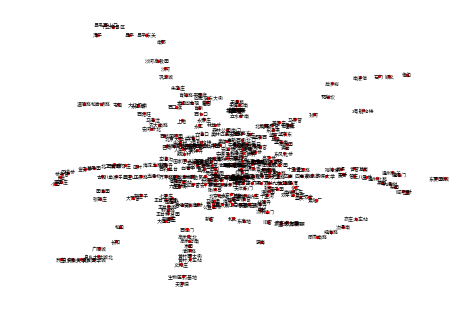

In [23]:
nx.draw(station_graph,  sub_staion_data,with_labels=True, node_size=5, font_size=5)

# 课堂上的相邻可达的路径都是根据设定了距离门槛值，但针对北京地铁，实际上地铁站之间的可达顺序其实是每条路线上的相邻站点，或者是换乘的路线

## 所以，首先应该写一个各个地铁线之间能够互达的站点路线图，类似：


In [24]:
subs_stations = {'1号线': ['苹果园', '古城', '八角游乐园', '八宝山', '玉泉路', '五棵松', '万寿路', '公主坟', '军事博物馆', '木樨地', '南礼士路', '复兴门', '西单', '天安门西', '天安门东', '王府井', '东单', '建国门', '永安里', '国贸', '大望路', '四惠', '四惠东'], '2号线': ['西直门', '积水潭', '鼓楼大街', '安定门', '雍和宫', '东直门', '东四十条', '朝阳门', '建国门', '北京站', '崇文门', '前门', '和平门', '宣武门', '长椿街', '复兴门', '阜成门', '车公庄'], '4号线': ['安河桥北', '北宫门', '西苑', '圆明园', '北京大学东门', '中关村', '海淀黄庄', '人民大学', '魏公村', '国家图书馆', '动物园', '西直门', '新街口', '平安里', '西四', '灵境胡同', '西单', '宣武门', '菜市口', '陶然亭', '北京南站', '马家堡', '角门西', '公益西桥'], '5号线': ['宋家庄', '刘家窑', '蒲黄榆', '天坛东门', '磁器口', '崇文门', '东单', '灯市口', '东四', '张自忠路', '北新桥', '雍和宫', '和平里北街', '和平西桥', '惠新西街南口', '惠新西街北口', '大屯路东', '北苑路北', '立水桥南', '立水桥', '天通苑南', '天通苑', '天通苑北'], '6号线': ['金安桥', '苹果园', '杨庄', '西黄村', '廖公庄', '田村', '海淀五路居', '慈寿寺', '花园桥', '白石桥南', '车公庄西', '车公庄', '平安里', '北海北', '南锣鼓巷', '东四', '朝阳门', '东大桥', '呼家楼', '金台路', '十里堡', '青年路', '褡裢坡', '黄渠', '常营', '草房', '物资学院路', '通州北关', '通运门', '北运河西', '北运河东', '郝家府', '东夏园', '潞城'], '7号线': ['北京西站', '湾子', '达官营', '广安门内', '菜市口', '虎坊桥', '珠市口', '桥湾', '磁器口', '广渠门内', '广渠门外', '双井', '九龙山', '大郊亭', '百子湾', '化工', '南楼梓庄', '欢乐谷景区', '垡头', '双合', '焦化厂'], '8号线': ['朱辛庄', '育知路', '平西府', '回龙观东大街', '霍营', '育新', '西小口', '永泰庄', '林萃桥', '森林公园南门', '奥林匹克公园', '奥体中心', '北土城', '安华桥', '安德里北街', '鼓楼大街', '什刹海', '南锣鼓巷', '中国美术馆', '珠市口', '天桥', '永定门外', '木樨园', '海户屯', '大红门', '大红门南', '和义', '东高地', '火箭万源', '五福堂', '德茂', '瀛海'], '9号线': ['郭公庄', '丰台科技园', '科怡路', '丰台南路', '丰台东大街', '七里庄', '六里桥', '六里桥东', '北京西站', '军事博物馆', '白堆子', '白石桥南', '国家图书馆'], '10号线': ['巴沟', '苏州街', '海淀黄庄', '知春里', '知春路', '西土城', '牡丹园', '健德门', '北土城', '安贞门', '惠新西街南口', '芍药居', '太阳宫', '三元桥', '亮马桥', '农业展览馆', '团结湖', '呼家楼', '金台夕照', '国贸', '双井', '劲松', '潘家园', '十里河', '分钟寺', '成寿寺', '宋家庄', '石榴庄', '大红门', '角门东', '角门西', '草桥', '纪家庙', '首经贸', '丰台站', '泥洼', '西局', '六里桥', '莲花桥', '公主坟', '西钓鱼台', '慈寿寺', '车道沟', '长春桥', '火器营'], '13号线': ['西直门', '大钟寺', '知春路', '五道口', '上地', '西二旗', '龙泽', '回龙观', '霍营', '立水桥', '北苑', '望京西', '芍药居', '光熙门', '柳芳', '东直门'], '14号线': ['张郭庄', '园博园', '大瓦窑', '郭庄子', '大井', '七里庄', '西局', '善各庄', '陶然桥', '永定门外', '景泰', '方庄', '北工大西门', '平乐园', '北京南站', '蒲黄榆', '十里河', '九龙山', '大望路', '朝阳公园', '枣营', '东风北桥', '高家园', '阜通', '望京', '金台路', '将台', '望京南', '东湖渠', '来广营'], '15号线': ['俸伯', '顺义', '石门', '南法信', '后沙峪', '花梨坎', '国展', '孙河', '马泉营', '崔各庄', '望京东', '望京', '望京西', '关庄', '大屯路东', '安立路', '奥林匹克公园', '北沙滩', '六道口', '清华东路西口'], '16号线': ['西苑', '农大南路', '马连洼', '西北旺', '永丰南', '永丰', '屯佃', '稻香湖路', '温阳路', '北安河'], '八通线': ['四惠', '四惠东', '高碑店', '传媒大学', '双桥', '管庄', '八里桥', '通州北苑', '果园', '九棵树', '梨园', '临河里', '土桥'], '昌平线': ['昌平西山口', '十三陵景区', '昌平', '昌平东关', '北邵洼', '南邵', '沙河高教园', '沙河', '巩华城', '朱辛庄', '生命科学园', '西二旗'], '亦庄线': ['宋家庄', '肖村', '小红门', '旧宫', '亦庄桥', '亦庄文化园', '万源街', '荣京东街', '荣昌东街', '同济南路', '经海路', '次渠南', '次渠', '亦庄火车站'], '房山线': ['郭公庄', '大葆台', '稻田', '长阳', '篱笆房', '广阳城', '良乡大学城北', '良乡大学城', '良乡大学城西', '良乡南关', '苏庄'], '机场线': ['东直门', '三元桥', '3号航站楼', '2号航站楼'], '大兴线': ['公益西桥', '新宫', '西红门', '高米店北', '高米店南', '枣园', '清源路', '黄村西大街', '黄村火车站', '义和庄', '生物医药基地', '天宫院'], 'S1线': ['石厂', '小园', '栗园庄', '上岸', '桥户营', '四道桥', '金安桥']}

In [25]:
# -*- coding: utf-8 -*-
subs_stations = {'1号线': ['苹果园', '古城', '八角游乐园', '八宝山', '玉泉路', '五棵松', '万寿路', '公主坟', '军事博物馆', '木樨地', '南礼士路', '复兴门', '西单', '天安门西', '天安门东', '王府井', '东单', '建国门', '永安里', '国贸', '大望路', '四惠', '四惠东'], '2号线': ['西直门', '积水潭', '鼓楼大街', '安定门', '雍和宫', '东直门', '东四十条', '朝阳门', '建国门', '北京站', '崇文门', '前门', '和平门', '宣武门', '长椿街', '复兴门', '阜成门', '车公庄'], '4号线': ['安河桥北', '北宫门', '西苑', '圆明园', '北京大学东门', '中关村', '海淀黄庄', '人民大学', '魏公村', '国家图书馆', '动物园', '西直门', '新街口', '平安里', '西四', '灵境胡同', '西单', '宣武门', '菜市口', '陶然亭', '北京南站', '马家堡', '角门西', '公益西桥'], '5号线': ['宋家庄', '刘家窑', '蒲黄榆', '天坛东门', '磁器口', '崇文门', '东单', '灯市口', '东四', '张自忠路', '北新桥', '雍和宫', '和平里北街', '和平西桥', '惠新西街南口', '惠新西街北口', '大屯路东', '北苑路北', '立水桥南', '立水桥', '天通苑南', '天通苑', '天通苑北'], '6号线': ['金安桥', '苹果园', '杨庄', '西黄村', '廖公庄', '田村', '海淀五路居', '慈寿寺', '花园桥', '白石桥南', '车公庄西', '车公庄', '平安里', '北海北', '南锣鼓巷', '东四', '朝阳门', '东大桥', '呼家楼', '金台路', '十里堡', '青年路', '褡裢坡', '黄渠', '常营', '草房', '物资学院路', '通州北关', '通运门', '北运河西', '北运河东', '郝家府', '东夏园', '潞城'], '7号线': ['北京西站', '湾子', '达官营', '广安门内', '菜市口', '虎坊桥', '珠市口', '桥湾', '磁器口', '广渠门内', '广渠门外', '双井', '九龙山', '大郊亭', '百子湾', '化工', '南楼梓庄', '欢乐谷景区', '垡头', '双合', '焦化厂'], '8号线': ['朱辛庄', '育知路', '平西府', '回龙观东大街', '霍营', '育新', '西小口', '永泰庄', '林萃桥', '森林公园南门', '奥林匹克公园', '奥体中心', '北土城', '安华桥', '安德里北街', '鼓楼大街', '什刹海', '南锣鼓巷', '中国美术馆', '珠市口', '天桥', '永定门外', '木樨园', '海户屯', '大红门', '大红门南', '和义', '东高地', '火箭万源', '五福堂', '德茂', '瀛海'], '9号线': ['郭公庄', '丰台科技园', '科怡路', '丰台南路', '丰台东大街', '七里庄', '六里桥', '六里桥东', '北京西站', '军事博物馆', '白堆子', '白石桥南', '国家图书馆'], '10号线': ['巴沟', '苏州街', '海淀黄庄', '知春里', '知春路', '西土城', '牡丹园', '健德门', '北土城', '安贞门', '惠新西街南口', '芍药居', '太阳宫', '三元桥', '亮马桥', '农业展览馆', '团结湖', '呼家楼', '金台夕照', '国贸', '双井', '劲松', '潘家园', '十里河', '分钟寺', '成寿寺', '宋家庄', '石榴庄', '大红门', '角门东', '角门西', '草桥', '纪家庙', '首经贸', '丰台站', '泥洼', '西局', '六里桥', '莲花桥', '公主坟', '西钓鱼台', '慈寿寺', '车道沟', '长春桥', '火器营'], '13号线': ['西直门', '大钟寺', '知春路', '五道口', '上地', '西二旗', '龙泽', '回龙观', '霍营', '立水桥', '北苑', '望京西', '芍药居', '光熙门', '柳芳', '东直门'], '14号线': ['张郭庄', '园博园', '大瓦窑', '郭庄子', '大井', '七里庄', '西局', '善各庄', '陶然桥', '永定门外', '景泰', '方庄', '北工大西门', '平乐园', '北京南站', '蒲黄榆', '十里河', '九龙山', '大望路', '朝阳公园', '枣营', '东风北桥', '高家园', '阜通', '望京', '金台路', '将台', '望京南', '东湖渠', '来广营'], '15号线': ['俸伯', '顺义', '石门', '南法信', '后沙峪', '花梨坎', '国展', '孙河', '马泉营', '崔各庄', '望京东', '望京', '望京西', '关庄', '大屯路东', '安立路', '奥林匹克公园', '北沙滩', '六道口', '清华东路西口'], '16号线': ['西苑', '农大南路', '马连洼', '西北旺', '永丰南', '永丰', '屯佃', '稻香湖路', '温阳路', '北安河'], '八通线': ['四惠', '四惠东', '高碑店', '传媒大学', '双桥', '管庄', '八里桥', '通州北苑', '果园', '九棵树', '梨园', '临河里', '土桥'], '昌平线': ['昌平西山口', '十三陵景区', '昌平', '昌平东关', '北邵洼', '南邵', '沙河高教园', '沙河', '巩华城', '朱辛庄', '生命科学园', '西二旗'], '亦庄线': ['宋家庄', '肖村', '小红门', '旧宫', '亦庄桥', '亦庄文化园', '万源街', '荣京东街', '荣昌东街', '同济南路', '经海路', '次渠南', '次渠', '亦庄火车站'], '房山线': ['郭公庄', '大葆台', '稻田', '长阳', '篱笆房', '广阳城', '良乡大学城北', '良乡大学城', '良乡大学城西', '良乡南关', '苏庄'], '机场线': ['东直门', '三元桥', '3号航站楼', '2号航站楼'], '大兴线': ['公益西桥', '新宫', '西红门', '高米店北', '高米店南', '枣园', '清源路', '黄村西大街', '黄村火车站', '义和庄', '生物医药基地', '天宫院'], 'S1线': ['石厂', '小园', '栗园庄', '上岸', '桥户营', '四道桥', '金安桥']}
from collections import defaultdict
def sub_map(map):
    geo_subs = defaultdict(list)
    for i, stats in subs_stations.items():
        for k in range(len(stats)-1):
            # 正序写一遍
            geo_subs[stats[k]].append(stats[k+1])
            # 倒着写一遍
        for m in range(1, len(stats)):
            geo_subs[stats[-m]].append(stats[-(m+1)])

    return geo_subs

print(sub_map(subs_stations))

defaultdict(<class 'list'>, {'苹果园': ['古城', '杨庄', '金安桥'], '古城': ['八角游乐园', '苹果园'], '八角游乐园': ['八宝山', '古城'], '八宝山': ['玉泉路', '八角游乐园'], '玉泉路': ['五棵松', '八宝山'], '五棵松': ['万寿路', '玉泉路'], '万寿路': ['公主坟', '五棵松'], '公主坟': ['军事博物馆', '万寿路', '西钓鱼台', '莲花桥'], '军事博物馆': ['木樨地', '公主坟', '白堆子', '北京西站'], '木樨地': ['南礼士路', '军事博物馆'], '南礼士路': ['复兴门', '木樨地'], '复兴门': ['西单', '南礼士路', '阜成门', '长椿街'], '西单': ['天安门西', '复兴门', '宣武门', '灵境胡同'], '天安门西': ['天安门东', '西单'], '天安门东': ['王府井', '天安门西'], '王府井': ['东单', '天安门东'], '东单': ['建国门', '王府井', '灯市口', '崇文门'], '建国门': ['永安里', '东单', '北京站', '朝阳门'], '永安里': ['国贸', '建国门'], '国贸': ['大望路', '永安里', '双井', '金台夕照'], '大望路': ['四惠', '国贸', '朝阳公园', '九龙山'], '四惠': ['四惠东', '大望路', '四惠东'], '四惠东': ['四惠', '高碑店', '四惠'], '西直门': ['积水潭', '新街口', '动物园', '大钟寺'], '积水潭': ['鼓楼大街', '西直门'], '鼓楼大街': ['安定门', '积水潭', '什刹海', '安德里北街'], '安定门': ['雍和宫', '鼓楼大街'], '雍和宫': ['东直门', '安定门', '和平里北街', '北新桥'], '东直门': ['东四十条', '雍和宫', '柳芳', '三元桥'], '东四十条': ['朝阳门', '东直门'], '朝阳门': ['建国门', '东四十条', '东大桥', '东四'], '北京站': ['崇文门', '建国门'], '崇文门': ['前门', '北

## 接下来就是进入正题的时候，思考广度优先还是深度优先？

In [30]:
station_connection = sub_map(subs_stations)

In [31]:
station_with_road = nx.Graph(station_connection)

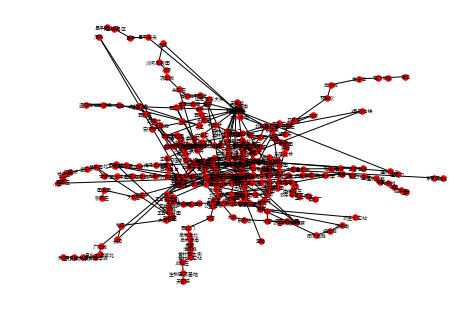

In [32]:
nx.draw(station_with_road, sub_staion_data, with_labels=True, font_size=5, node_size=30)

### 线条好乱啊，不大对啊感觉

In [34]:
def bfs(graph, start):
    visited = [start]
    seen = srt()
    while visited:
        frontinter = visited.pop()
        if frontinter in seen: continue
        for successor in graph[frontinter]:
                if successor in seen: continue
                print(successor) 
                visited = [successor] + visited
        seen.add(frontinter)
    return seen

In [52]:
def search(start, destination, connection_grpah, sort_candidate):
    pathes = [[start]]
    
    visitied = set()
    
    while pathes: # if we find existing pathes
        path = pathes.pop(0)
        froninter = path[-1]
        
        if froninter in visitied: continue
            
        successors = connection_grpah[froninter]
        
        for city in successors:
            if city in path: continue  # eliminate loop
                
            new_path = path + [city]
            
            pathes.append(new_path)
            
            if city == destination: return new_path
        
        visitied.add(froninter)
        
        pathes = sort_candidate(pathes) 

In [48]:
def tranfer_stations_first(pathes):
    return sorted(pathes, key=len)

In [53]:
def shortest_path_first(pathes):
    
    if len(pathes) <= 1: return pathes
    
    def get_path_distnace(path):
        distance = 0
        for station in path[:-1]:
            distance += get_geo_distance(station, path[-1])
            
        return distance

    return sorted(pathes, key=get_path_distnace)

In [54]:
station_connection_info = defaultdict(list)

In [55]:
station_connection_info.update(station_connection)

In [56]:
search('西直门','四惠东',station_connection_info,sort_candidate=shortest_path_first)

['西直门',
 '积水潭',
 '鼓楼大街',
 '安定门',
 '雍和宫',
 '东直门',
 '东四十条',
 '朝阳门',
 '东大桥',
 '呼家楼',
 '金台夕照',
 '国贸',
 '大望路',
 '四惠',
 '四惠东']

In [63]:
def pretty_print(cities):
    print('🚗->'.join(cities))

In [65]:
pretty_print(search('西直门','东直门',station_connection_info,sort_candidate=shortest_path_first))

西直门🚗->积水潭🚗->鼓楼大街🚗->安定门🚗->雍和宫🚗->东直门
